In [271]:
import yaml
yaml.warnings({'YAMLLoadWarning': False})
import pandas as pd
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import validation_curve
from sklearn.svm import SVC
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt


In [272]:
# Configuration parameters
config_file = "../config/config_simple_ugr16.yaml"
model = "svc"
rep = 1
kfold = 2

In [273]:
def load_config(path_to_config_file):
    """
        Load config file

        Parameters
        ----------
        path_to_config_file: str
            Path to *.yaml file

        Return
        ------
        configuration:
            The yaml file loaded

        Raise
        -----
        e: Exception
             If something was wrong.


    """
    try:
        with open(path_to_config_file) as f:
            configuration = yaml.load(f)
    except Exception as e:
        print("There was an ERROR loading the configuration file: " + path_to_config_file)
        raise e

    return configuration

In [274]:
# load configuration
config = load_config(config_file)

In [275]:
# Data root path
root_path = config['folder_paths']['root_path']
# Reading dataset and aux files for selecting folds and reps and for getting variable selection.
mc_file = config['file_paths']['mc_file']
mcfold_file = config['file_paths']['mcfold_file']
mcvars_file = config['file_paths']['mcvars_file']

df = pd.read_csv(root_path + mc_file)
df_folds = pd.read_csv(root_path + mcfold_file)
df_vars = pd.read_csv(root_path + mcvars_file)

In [276]:
df.shape, df_folds.shape, df_vars.shape

((47275, 145), (47275, 20), (100, 136))

In [277]:
# Feature selection
d = (df_vars.groupby('repeticion').groups[rep]) & (df_vars.groupby('caja.de.test').groups[kfold])

size = df_vars.shape[1]
f = ['']

for i in range(1, size):
    if int(df_vars.iloc[d, i]) == 1:
        f.append(df_vars.iloc[d, i].name)

f.remove("")
if kfold == 1:
    f.remove("caja.de.test")

In [278]:
# Applying feature selection and outcome 
X = df[f]
y = df['outcome']

In [279]:
df_no_labels = df.iloc[:,1:-10] # Removing ts and labels columns. 

In [280]:
print("{0} chosen variables from {1}".format(len(f),df_no_labels.shape[1]))

82 chosen variables from 134


In [281]:
# Making TRAINING and TEST datasets according to the number of fold

group = 'REP.' + str(rep)
rows_fold = df_folds.iloc[df_folds.groupby(group).groups[kfold]].index
No_rows_fold = df_folds[df_folds[group] != kfold][group].index

# Getting labels from config file

labels = config['labels']

# Data TRAIN and LABEL

X_train = X.drop(X.index[rows_fold])
y_train = y.drop(y.index[rows_fold])
y_train_bina = label_binarize(y_train, classes=labels)

# Data TEST and LABEL

X_test = X.drop(X.index[No_rows_fold])
y_test = y.drop(y.index[No_rows_fold])
y_test_bina = label_binarize(y_test, classes=labels)

# Data normalization
X_train_scaled = StandardScaler().fit_transform(X_train)
X_test_scaled = StandardScaler().fit_transform(X_test)

In [282]:
parameters = {'C': Real(config['models']['svc']['hyperparameters']['C'][0],
                      config['models']['svc']['hyperparameters']['C'][1],
                      prior='log-uniform')}

# Adding gamma when SVC kernel is rbf
if config['models']['svc']['hyperparameters']['kernel'] == 'rbf':
    parameters['gamma'] = Real(config['models']['svc']['hyperparameters']['gamma'][0],
                               config['models']['svc']['hyperparameters']['gamma'][1],
                               prior='uniform')

model_grid = SVC(random_state=config['models']['svc']['general']['random_state'],
                 kernel = config['models']['svc']['hyperparameters']['kernel'], verbose=3)

In [283]:
model_grid

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=0,
    shrinking=True, tol=0.001, verbose=3)

In [284]:
clf = BayesSearchCV(model_grid, parameters,
                            n_iter= config['hyper_bayesian']['n_iter'],
                            verbose=3,
                            n_jobs= config['hyper_bayesian']['n_jobs'],
                            cv = config['hyper_bayesian']['cv'],
                            n_points = config['hyper_bayesian']['n_points'],
                            scoring = config['hyper_bayesian']['scoring'],
                            random_state = config['hyper_bayesian']['random_state'])

In [285]:
clf

BayesSearchCV(cv=5, error_score='raise',
              estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                            decision_function_shape='ovr', degree=3,
                            gamma='auto_deprecated', kernel='linear',
                            max_iter=-1, probability=False, random_state=0,
                            shrinking=True, tol=0.001, verbose=3),
              fit_params=None, iid=True, n_iter=30, n_jobs=15, n_points=3,
              optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=0,
              refit=True, return_train_score=False, scoring='f1_macro',
              search_spaces={'C': Real(low=0.1, high=10, prior='log-uniform', transform='identity')},
              verbose=3)

In [45]:
# C=[0.1,100] log-uniform
#obs = 40000
#clf.fit(X_train_scaled[:obs,:], y_train[:obs])
import time
start = time.time()
clf.fit(X_train_scaled, y_train)
end = time.time()
print(end - start)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed: 16.2min remaining: 24.3min
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed: 17.2min finished


[LibSVM]2835.747947692871


In [49]:
# C=[0.1, 100] log-uniform y 30 iteracciones que es lo que hacíamos ~ un día para un k-fold y un rep!!!!!
(2835/60*30)/60

23.625

In [46]:
pd.DataFrame(clf.cv_results_)

,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params
0,0.767279,0.792597,0.67733,0.751157,0.736543,0.744983,0.038604,1,989.365856,29.802487,10.215385,0.393633,3.916449,{'C': 3.916449174261764}


In [88]:
# C=[0.1,1] uniform
import time
start = time.time()
clf.fit(X_train_scaled, y_train)
end = time.time()
print(end - start)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:  4.5min remaining:  6.8min
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:  4.8min finished


[LibSVM]762.1214115619659


In [89]:
pd.DataFrame(clf.cv_results_)

,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params
0,0.57263,0.606063,0.58064,0.614915,0.599302,0.594707,0.015772,1,261.680775,7.846287,13.422703,0.245385,0.577868,{'C': 0.5778677484569327}


In [269]:
clf

BayesSearchCV(cv=5, error_score='raise',
              estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                            decision_function_shape='ovr', degree=3,
                            gamma='auto_deprecated', kernel='linear',
                            max_iter=-1, probability=False, random_state=0,
                            shrinking=True, tol=0.001, verbose=3),
              fit_params=None, iid=True, n_iter=30, n_jobs=10, n_points=1,
              optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=0,
              refit=True, return_train_score=False, scoring='f1_macro',
              search_spaces={'C': Real(low=0.1, high=10, prior='log-uniform', transform='identity')},
              verbose=3)

In [286]:
# C=[0.1,10] log-uniform
import time
#obs=10000
start = time.time()
clf.fit(X_train_scaled, y_train)
#clf.fit(X_train_scaled, y_train)
end = time.time()
print(end - start)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   4 out of  15 | elapsed:  7.7min remaining: 21.0min
[Parallel(n_jobs=15)]: Done  10 out of  15 | elapsed: 10.2min remaining:  5.1min
[Parallel(n_jobs=15)]: Done  15 out of  15 | elapsed: 12.4min finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   4 out of  15 | elapsed:  3.4min remaining:  9.3min
[Parallel(n_jobs=15)]: Done  10 out of  15 | elapsed: 32.6min remaining: 16.3min
[Parallel(n_jobs=15)]: Done  15 out of  15 | elapsed: 41.4min finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   4 out of  15 | elapsed:  2.3min remaining:  6.3min
[Parallel(n_jobs=15)]: Done  10 out of  15 | elapsed:  4.1min remaining:  2.0min
[Parallel(n_jobs=15)]: Done  15 out of  15 | elapsed:  7.0min finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   4 out of  15 | elapsed:  1.9min remaining:  5.3min
[Parallel(n_jobs=15)]: Done  10 out of  15 | elapsed:  2.0min remaining:  1.0min
[Parallel(n_jobs=15)]: Done  15 out of  15 | elapsed:  2.7min finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   4 out of  15 | elapsed:  1.9min remaining:  5.2min
[Parallel(n_jobs=15)]: Done  10 out of  15 | elapsed:  2.0min remaining:   59.7s
[Parallel(n_jobs=15)]: Done  15 out of  15 | elapsed:  2.1min finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   4 out of  15 | elapsed:  1.9min remaining:  5.2min
[Parallel(n_jobs=15)]: Done  10 out of  15 | elapsed:  2.0min remaining:   59.0s
[Parallel(n_jobs=15)]: Done  15 out of  15 | elapsed:  2.1min finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   4 out of  15 | elapsed:  1.9min remaining:  5.2min
[Parallel(n_jobs=15)]: Done  10 out of  15 | elapsed:  2.0min remaining:   59.3s
[Parallel(n_jobs=15)]: Done  15 out of  15 | elapsed:  2.1min finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   4 out of  15 | elapsed:  2.3min remaining:  6.3min
[Parallel(n_jobs=15)]: Done  10 out of  15 | elapsed:  2.4min remaining:  1.2min
[Parallel(n_jobs=15)]: Done  15 out of  15 | elapsed:  2.5min finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   4 out of  15 | elapsed:  1.9min remaining:  5.2min
[Parallel(n_jobs=15)]: Done  10 out of  15 | elapsed:  2.0min remaining:   59.0s
[Parallel(n_jobs=15)]: Done  15 out of  15 | elapsed:  2.1min finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   4 out of  15 | elapsed:  1.9min remaining:  5.2min
[Parallel(n_jobs=15)]: Done  10 out of  15 | elapsed:  2.0min remaining:  1.0min
[Parallel(n_jobs=15)]: Done  15 out of  15 | elapsed:  2.1min finished


[LibSVM]4728.884869098663


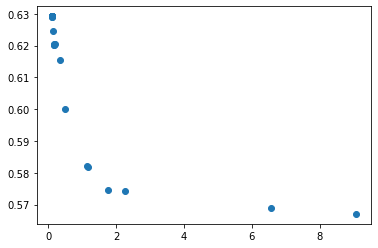

In [287]:
df=pd.DataFrame(clf.cv_results_)
plt.plot(df['param_C'],df['mean_test_score'],'o')

<AxesSubplot:>

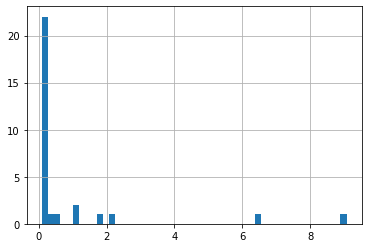

In [290]:
df['param_C'].hist(bins=50)

In [288]:
clf.best_estimator_

SVC(C=0.10003206436835438, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=0,
    shrinking=True, tol=0.001, verbose=3)

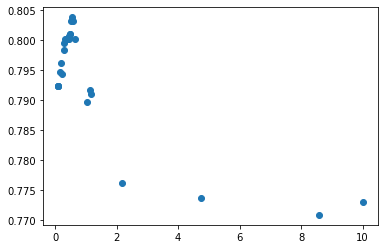

In [250]:
df=pd.DataFrame(clf.cv_results_)
plt.plot(df['param_C'],df['mean_test_score'],'o')



In [265]:
# Each class is modeled separately.
tmodeldef = OneVsRestClassifier(clf, n_jobs=len(labels))
tmodeldef

OneVsRestClassifier(estimator=BayesSearchCV(cv=5, error_score='raise',
                                            estimator=SVC(C=1.0, cache_size=200,
                                                          class_weight=None,
                                                          coef0=0.0,
                                                          decision_function_shape='ovr',
                                                          degree=3,
                                                          gamma='auto_deprecated',
                                                          kernel='linear',
                                                          max_iter=-1,
                                                          probability=False,
                                                          random_state=0,
                                                          shrinking=True,
                                                          tol=0.001,
                      

In [260]:
y_train_bina[:obs,:]

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [266]:
start = time.time()
tmodeldef.fit(X_train_scaled[:obs,:], y_train_bina[:obs,:])
end = time.time()
print(end - start)

25.139787912368774


In [262]:
# Training performance
predictions_train = tmodeldef.predict(X_train_scaled)

In [263]:
predictions_train

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [36]:
tmodeldef.estimators_

[SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
     kernel='rbf', max_iter=-1, probability=False, random_state=0,
     shrinking=True, tol=0.001, verbose=True),
 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
     kernel='rbf', max_iter=-1, probability=False, random_state=0,
     shrinking=True, tol=0.001, verbose=True),
 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
     kernel='rbf', max_iter=-1, probability=False, random_state=0,
     shrinking=True, tol=0.001, verbose=True),
 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
     kernel='rbf', max_iter=-1, probability=False, random_state=0,
     shrinking=True, tol=0.001, verbose=True),
 SVC(C=1.0, cache_size=200, 

In [37]:
tmodeldef.classes_

array([0, 1, 2, 3, 4, 5, 6])

In [40]:
tmodeldef.label_binarizer_.

array([0, 1, 2, 3, 4, 5, 6])

In [59]:
y_train.value_counts()

background     24073
spam           12769
nerisbotnet      475
dos              334
scan             141
sshscan           21
udpscan            8
Name: outcome, dtype: int64

In [63]:
X_train

,srcip_default,dstip_private,sport_quote,sport_ftp_control,sport_ssh,sport_telnet,sport_smtp,sport_dns,sport_bootp,sport_finger,...,protocol_igmp,protocol_other,tcpflags_RST,tcpflags_FIN,srctos_192,srctos_other,npackets_verylow,npackets_medium,npackets_veryhigh,nbytes_high
0,0,1,0,26,5,1,460,7409,0,0,...,0,4,1792,11143,29,1628,17556,1731,22,1453
1,0,30,0,122,43,35,1047,14231,0,0,...,0,61,7982,40944,154,13956,52000,6046,183,5516
2,0,24,0,149,93,31,973,15167,0,0,...,0,69,9247,43114,163,17190,56926,7017,207,5926
3,0,29,0,87,101,36,961,14702,0,0,...,0,75,8613,43040,149,16243,54994,6585,198,5729
4,0,25,0,84,65,38,892,15148,0,0,...,0,68,9037,42280,133,21533,60244,5947,206,5344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47270,0,25,0,332,88,48,417,10084,0,0,...,0,112,7138,36343,186,13091,49971,4737,153,3841
47271,0,27,0,357,119,37,367,9838,0,0,...,0,100,7254,34508,200,13245,49816,5263,130,4505
47272,0,29,0,374,98,39,636,9715,0,0,...,0,115,7816,35799,165,13872,51005,5087,149,4176
47273,0,29,0,345,93,55,639,9233,0,0,...,0,126,7102,35226,156,13452,48327,4754,195,3945
